In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

In [159]:
# Create images with random rectangles and bounding boxes. 
num_imgs = 50000

img_size = 8
min_object_size = 1
max_object_size = 4
num_objects = 1
color_size = 1

bboxes = np.zeros((num_imgs, num_objects, 4))
imgs = np.zeros((num_imgs, img_size, img_size, color_size))  # set background to 0

for i_img in range(num_imgs):
    for i_object in range(num_objects):
        w, h = np.random.randint(min_object_size, max_object_size, size=2)
        x = np.random.randint(0, img_size - w)
        y = np.random.randint(0, img_size - h)
        imgs[i_img, x:x+w, y:y+h, 0] = 1.  # set rectangle to 1
        bboxes[i_img, i_object] = [x, y, w, h]
        
imgs.shape, bboxes.shape

((50000, 8, 8, 1), (50000, 1, 4))

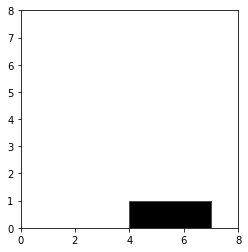

In [160]:
i = 0
plt.imshow(imgs[i].reshape(8, -1).T, cmap='Greys', interpolation='none', origin='lower', extent=[0, img_size, 0, img_size])
for bbox in bboxes[i]:
    plt.gca().add_patch(matplotlib.patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], ec='r', fc='none'))

In [113]:
# Reshape and normalize the image data to mean 0 and std 1. 
#X = (imgs.reshape(num_imgs, -1) - np.mean(imgs)) / np.std(imgs)
X = (imgs - np.mean(imgs)) / np.std(imgs)
X.shape, np.mean(X), np.std(X)

((50000, 8, 8, 1), 3.880451515669847e-17, 1.0)

In [161]:
# Normalize x, y, w, h by img_size, so that all values are between 0 and 1.
# Important: Do not shift to negative values (e.g. by setting to mean 0), because the IOU calculation needs positive w and h.
y = bboxes.reshape(num_imgs, -1) / img_size
y.shape, np.mean(y), np.std(y)

((50000, 4), 2.24976, 1.4011673498907973)

In [162]:
# Split training and test.
i = int(0.8 * num_imgs)
train_X = X[:i]
test_X = X[i:]
train_y = y[:i]
test_y = y[i:]
test_imgs = imgs[i:]
test_bboxes = bboxes[i:]

In [163]:
import torch.nn as nn
import torch

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=4, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=4, out_channels=8, kernel_size=3)
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=1)
        self.fc1 = nn.Linear(36, 200)
        self.relu = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout(p=0.2)
        self.fc2 = nn.Linear(200, y.shape[-1])
    
    def forward(self, x):
        y = x.view(x.size(0), 1, 8, 8)
        y = self.conv1(y)
        #y = self.relu(y) 
        
        # Second Convolutional Layer
        #y = self.conv2(y)
        y = self.maxpool(y)
        y = self.relu(y)
                        
        # Flattening 
        y = y.view(y.size(0), -1)
        
        y = self.fc1(y)
        y = self.relu(y)
        y = self.dropout(y)
        y = self.fc2(y)
        
        return y

In [164]:
epochs = 100

model = Net()
criterion = nn.MSELoss()
#lr=1.0, rho=0.95, epsilon=None, decay=0.0
optimizer = torch.optim.Adadelta(model.parameters(), lr=1.0, rho=0.95)

for e in range(epochs):
    print("Epoch", str(e + 1) + '/' + str(epochs))
    X_tensor = torch.from_numpy(train_X).float()
    Y_tensor = torch.from_numpy(train_y).float()
    optimizer.zero_grad()                             # Intialize the hidden weight to all zeros
    outputs = model(X_tensor)                           # Forward pass: compute the output class given a review
    loss = criterion(outputs, Y_tensor)               # Compute the loss: difference between the output class and the pre-given label
    loss.backward()                                   # Backward pass: compute the weight
    optimizer.step()                                  # Optimizer: update the weights of hidden nodes
    print("Loss:", loss.item())

Epoch 1/100
Loss: 6.990885257720947
Epoch 2/100
Loss: 5.781137943267822
Epoch 3/100
Loss: 4.6541900634765625
Epoch 4/100
Loss: 3.5807013511657715
Epoch 5/100
Loss: 2.996645450592041
Epoch 6/100
Loss: 2.7590341567993164
Epoch 7/100
Loss: 2.564845561981201
Epoch 8/100
Loss: 2.40669846534729
Epoch 9/100
Loss: 2.2736308574676514
Epoch 10/100
Loss: 2.1794772148132324
Epoch 11/100
Loss: 2.1216959953308105
Epoch 12/100
Loss: 2.078296661376953
Epoch 13/100
Loss: 2.054555892944336
Epoch 14/100
Loss: 2.03230619430542
Epoch 15/100
Loss: 2.0225577354431152
Epoch 16/100
Loss: 2.0101425647735596
Epoch 17/100
Loss: 1.9997066259384155
Epoch 18/100
Loss: 1.9931418895721436
Epoch 19/100
Loss: 1.9912067651748657
Epoch 20/100
Loss: 1.9851099252700806
Epoch 21/100
Loss: 1.9821757078170776
Epoch 22/100
Loss: 1.9772411584854126
Epoch 23/100
Loss: 1.9758599996566772
Epoch 24/100
Loss: 1.969507098197937
Epoch 25/100
Loss: 1.9716682434082031
Epoch 26/100
Loss: 1.9683771133422852
Epoch 27/100
Loss: 1.96589314937

In [165]:
# Predict bounding boxes on the test images.
pred_y = model(torch.from_numpy(test_X).float())
pred_bboxes = pred_y * img_size
pred_bboxes = pred_bboxes.reshape(len(pred_bboxes), num_objects, -1)
pred_bboxes.shape

torch.Size([10000, 1, 4])

In [166]:
def IOU(bbox1, bbox2):
    '''Calculate overlap between two bounding boxes [x, y, w, h] as the area of intersection over the area of unity'''
    x1, y1, w1, h1 = bbox1[0], bbox1[1], bbox1[2], bbox1[3]
    x2, y2, w2, h2 = bbox2[0], bbox2[1], bbox2[2], bbox2[3]

    w_I = min(x1 + w1, x2 + w2) - max(x1, x2)
    h_I = min(y1 + h1, y2 + h2) - max(y1, y2)
    if w_I <= 0 or h_I <= 0:  # no overlap
        return 0.
    I = w_I * h_I

    U = w1 * h1 + w2 * h2 - I

    return I / U

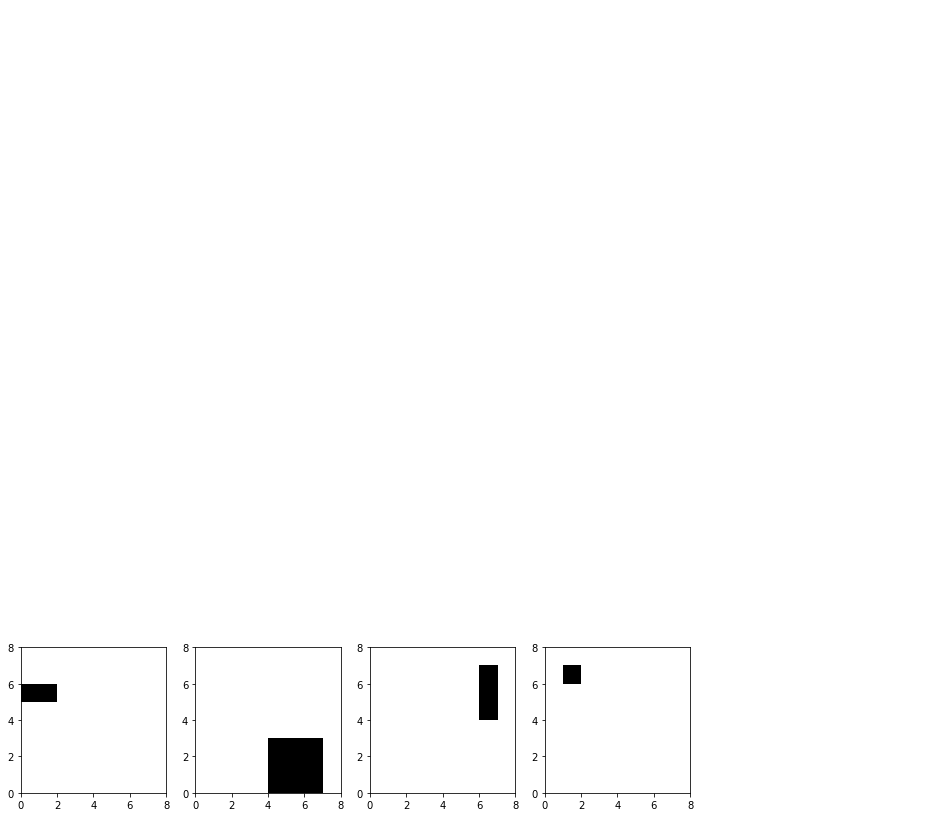

In [167]:
# Show a few images and predicted bounding boxes from the test dataset. 
plt.figure(figsize=(12, 3))
for i_subplot in range(1, 5):
    plt.subplot(1, 4, i_subplot)
    i = np.random.randint(len(test_imgs))
    plt.imshow(test_imgs[i].reshape(8, -1).T, cmap='Greys', interpolation='none', origin='lower', extent=[0, img_size, 0, img_size])
    for pred_bbox, exp_bbox in zip(pred_bboxes[i], test_bboxes[i]):
        plt.gca().add_patch(matplotlib.patches.Rectangle((pred_bbox[0], pred_bbox[1]), pred_bbox[2], pred_bbox[3], ec='r', fc='none'))
        plt.annotate('IOU: {:.2f}'.format(IOU(pred_bbox, exp_bbox)), (pred_bbox[0], pred_bbox[1]+pred_bbox[3]+0.2), color='r')
        
# plt.savefig('plots/bw-single-rectangle_prediction.png', dpi=300)

In [168]:
# Calculate the mean IOU (overlap) between the predicted and expected bounding boxes on the test dataset. 
summed_IOU = 0.
for pred_bbox, test_bbox in zip(pred_bboxes.reshape(-1, 4), test_bboxes.reshape(-1, 4)):
    summed_IOU += IOU(pred_bbox, test_bbox)
mean_IOU = summed_IOU / len(pred_bboxes)
mean_IOU

0.0